In [1]:
import numpy as np
from sympy import Eq, symbols, diff, Derivative as D, Function, sqrt as sqrt_, Abs as abs_, solve
from math import sqrt
from scipy.stats import norm
from matplotlib import pyplot as plt
from ammgammalib import *

# AMM Gamma vs Derivatives Gamma

This notebook relates to a [Medium article][medium] ([part 2][medium2]). The notebook itself is available [on Github][github] and [on Binder][binder].

[github]:https://github.com/topazeblue/notebooks/blob/main/AMMs/2022/202212_AMM_Gamma_vs_Derivatives_Gamma.ipynb
[binder]:https://mybinder.org/v2/gh/topazeblue/notebooks/main?labpath=AMMs/2022/202212_AMM_Gamma_vs_Derivatives_Gamma.ipynb
[medium]:https://medium.com/@odtorson/why-amm-gamma-and-derivatives-gamma-is-different-70b51c4692f0
[medium2]:https://medium.com/@odtorson/why-amm-gamma-and-derivatives-gamma-is-different-70b51c4692f0



## Formulas

In [2]:
x_ = symbols("x")

In [3]:
diff(diff(  0.5*(x_-1)**2  , x_), x_).subs(x_,1)

1.00000000000000

In [4]:
diff(diff(  4*((1+x_)-sqrt_(x_))  , x_), x_).subs(x_,1)

1

## Part 1 -- no fees

In [5]:
square_f = lambda x: 0.5*(x-1)**2
hedged_f = lambda x: 4*((1+x)/2 - sqrt(x))
amm_f = lambda x,f: gamma_gain(1,x,0.75, f)
x_r = np.linspace(0.001,2,1000)
t_r = np.linspace(min(x_r)**2,max(x_r)**2,1000)
t2_r = np.linspace(min(x_r)**2,1**2,100)

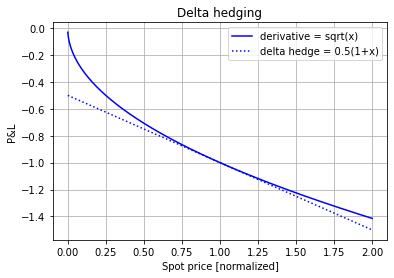

In [6]:
plt.plot(x_r, A(lambda x: -sqrt(x), x_r), color="blue", label="derivative = sqrt(x)")
plt.plot(x_r, A(lambda x: -0.5*(1+x), x_r), color="blue", linestyle="dotted", label="delta hedge = 0.5(1+x)")
plt.legend()
plt.title(f"Delta hedging")
plt.xlabel("Spot price [normalized]")
plt.ylabel("P&L")
plt.grid()

First we plot the `hedged` profile on its own. It corresponds to a hedged square root profile. We see that it is flat and looks quadratic around $x=1$. It is also the IL profile, which is not a coincidence. We also plotted the best-matching quadratic profile. The respective functions are given by

$$
PV_{hedged}(x) = \frac{1+x}{2} - \sqrt{x} \\
PV_{square}(x) = (x-1)^2
$$



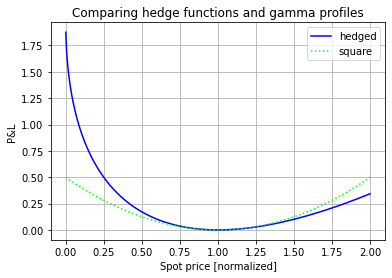

In [7]:
plt.plot(x_r, A(hedged_f, x_r), color="blue", label="hedged")
plt.plot(x_r, A(square_f, x_r), color="lime", linestyle="dotted", label="square")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Spot price [normalized]")
plt.ylabel("P&L")
plt.grid()

Then we plot the AMM profile on its own. It is the difference between the current market price $x$ and the geometric average between the current price and the old price $x_{old}=1$, because we know that an AMM always trades at this price when markets move. We see that it is linear around its cusp.

$$
PV_{amm}(x) = |x-\sqrt{x\cdot 1}|
$$

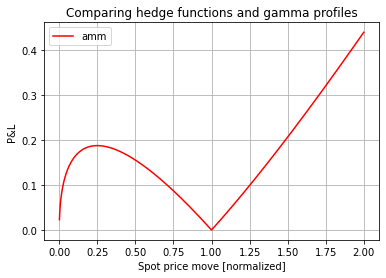

In [8]:
plt.plot(x_r, A(lambda x: amm_f(x,0), x_r), color="red", label="amm")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Spot price move [normalized]")
plt.ylabel("P&L")
plt.grid()

Here we are looking at profiles that are hedged at $x=1$ where $x$ is some normalized spot value. The `hedged` profile is the square root profile which delta-hedged (which happens to be the classic IL profile as well), `amm` is the profile that is created by the AMM arbitrage flow (trade at $\sqrt{x_{old}x}$ when prices are at $x$), and `square` is pure quadratic payoff profile for reference.

The notional amounts have been chosen to roughly balance the charts, but there is no strict size relationship between the three profiles.

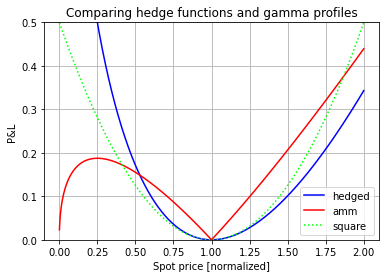

In [9]:
plt.plot(x_r, A(hedged_f, x_r), color="blue", label="hedged")
plt.plot(x_r, A(lambda x: amm_f(x,0), x_r), color="red", label="amm")
plt.plot(x_r, A(square_f, x_r), color="lime", linestyle="dotted", label="square")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Spot price [normalized]")
plt.ylabel("P&L")
plt.ylim(0,0.5)
plt.grid()

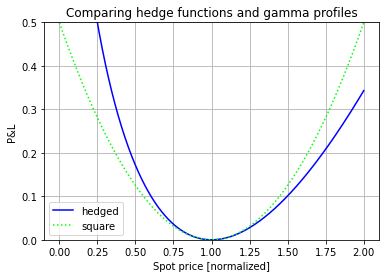

In [10]:
plt.plot(x_r, A(hedged_f, x_r), color="blue", label="hedged")
#plt.plot(x_r, A(lambda x: amm_f(x,0), x_r), color="red", label="amm")
plt.plot(x_r, A(square_f, x_r), color="lime", linestyle="dotted", label="square")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Spot price [normalized]")
plt.ylabel("P&L")
plt.ylim(0,0.5)
plt.grid()

We now perform the break-even analysis: we use a time-like variable $\tau$ that represents rebalancing frequency and we assume that $\Delta x\simeq \sqrt{\tau}$ (volatility has been integrated into the scale of $\tau$. Rather than doing a full Monte Carlo we simply assume a one standard deviation move upwards in a time period tau, hence the $\sqrt{\tau}$ term. We then need to divide by $\tau$ to take into account for the fact that the smaller $\tau$, the more often the rebalancing happens.

We see the `square` profile is flat as it should be: on a perfect square profile, rebalancing frequency does not matter, as the $x^2$ is balanced by the $\sqrt{\tau}$ size of the moves. For the `hedged` profile we see that rebalancing frequency does matter, but not much. The reason for this is higher order terms, as the profile is not fully quadratic. For the `amm` profile finally we find a massive divergence for high-frequency rebalancing (ie $\tau\simeq 0$) because the growth of this profile around the pivot point $x=1$ is not quadratic but linear.

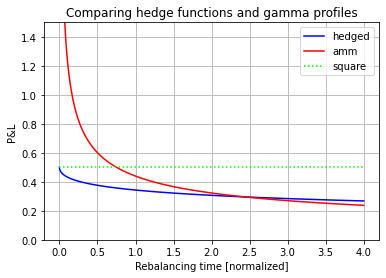

In [11]:
E = lambda f,t: 0.5*(f(1+sqrt(t))+f(1+sqrt(t))) # EV under binary distribution(mean=1, sdev=sqrt(t))

plt.plot(t_r, A(lambda t: E(hedged_f,t) / t, t_r), color="blue", label="hedged")
plt.plot(t_r, A(lambda t: E(lambda x: amm_f(x,0),t) / t, t_r), color="red", label="amm")
plt.plot(t_r, A(lambda t: E(square_f,t) / t, t_r), color="lime", linestyle="dotted", label="square")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Rebalancing time [normalized]")
plt.ylabel("P&L")
plt.ylim(0,1.5)
plt.grid()

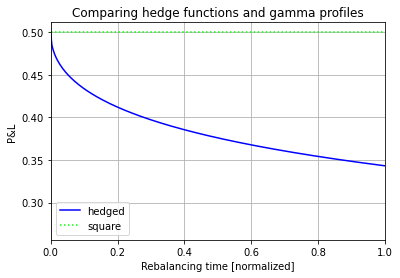

In [12]:
plt.plot(t_r, A(lambda t: E(hedged_f,t) / t, t_r), color="blue", label="hedged")
#plt.plot(t_r, A(lambda t: E(lambda x: amm_f(x,0),t) / t, t_r), color="red", label="amm")
plt.plot(t_r, A(lambda t: E(square_f,t) / t, t_r), color="lime", linestyle="dotted", label="square")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Rebalancing time [normalized]")
plt.ylabel("P&L")
plt.xlim(0,1)
plt.grid()

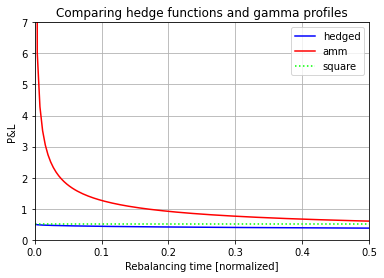

In [13]:
E = lambda f,t: 0.5*(f(1+sqrt(t))+f(1+sqrt(t))) # EV under binary distribution(mean=1, sdev=sqrt(t))

plt.plot(t_r, A(lambda t: E(hedged_f,t) / t, t_r), color="blue", label="hedged")
plt.plot(t_r, A(lambda t: E(lambda x: amm_f(x,0),t) / t, t_r), color="red", label="amm")
plt.plot(t_r, A(lambda t: E(square_f,t) / t, t_r), color="lime", linestyle="dotted", label="square")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Rebalancing time [normalized]")
plt.ylabel("P&L")
plt.ylim(0,7)
plt.xlim(0,0.5)
plt.grid()

## Part 2 -- With fees

In [14]:
feepc = 0.10
square2_f = lambda x: 1*(x-1)**2
tt_r = np.linspace(min(x_r)**2,0.1,1000)

Introducing fees, the cusp of the profile gets separated into two strikes. In option speak: [the strangle profile becomes a straddle profile](https://tickertape.tdameritrade.com/trading/options-straddle-strangle-volatility-strategies-16208). We are also drawing a quadratic profile as reference (note that this is not the same quadratic profile as shown above, hence the different line style)

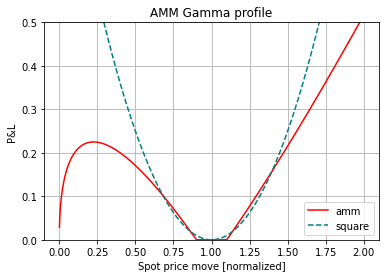

In [15]:
plt.plot(x_r, A(lambda x: amm_f(x,feepc), x_r), color="red", label="amm")
plt.plot(x_r, A(square2_f, x_r), linestyle="dashed", color="teal", label="square")
plt.legend()
plt.title(f"AMM Gamma profile")
plt.xlabel("Spot price move [normalized]")
plt.ylabel("P&L")
plt.ylim(0,0.5)
plt.grid()

Here the same chart as above, zoomed in. We note that the quadratic profile dominates the AMM profile around $x=1$, but goes below it further out. Note from the chart above that for very big moves, again the square profile dominates.

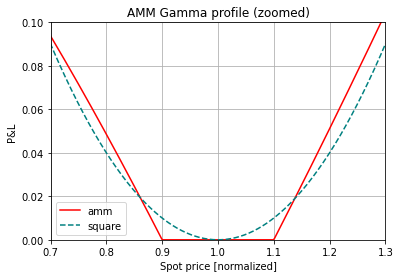

In [16]:
plt.plot(x_r, A(lambda x: amm_f(x,feepc), x_r), color="red", label="amm")
plt.plot(x_r, A(square2_f, x_r), linestyle="dashed", color="teal", label="square")
plt.legend()
plt.title(f"AMM Gamma profile (zoomed)")
plt.xlabel("Spot price [normalized]")
plt.ylabel("P&L")
plt.ylim(0,0.1)
plt.xlim(0.7, 1.3)
plt.grid()

Here we are again doing the rebalancing analysis: we look at the P&L per time period as a function of the rebalancing frequency (or rather, as a function of the rebalancing time). We see that it goes below the reference square profile both for very small and for very large rebalancing times, but goes above the square profile in the middle. 

This of course is related to the three domains identified above where in the middle and in the wings the square profile dominates the AMM profile, but in the middle the AMM profile dominates

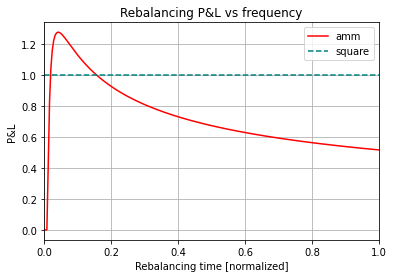

In [17]:
plt.plot(t_r, A(lambda t: E(lambda x: amm_f(x,feepc),t) / t, t_r), color="red", label="amm")
plt.plot(t_r, A(lambda t: E(square2_f,t) / t, t_r), linestyle="dashed", color="teal", label="square")
plt.legend()
plt.title(f"Rebalancing P&L vs frequency")
plt.xlabel("Rebalancing time [normalized]")
plt.ylabel("P&L")
plt.xlim(0,1)
plt.grid()

Here we zoom on the area around zero rebalancing time, ie instantaneous rebalancing. We see that there is a region where the P&L is zero, corresponding to a rebalancing time where the corresponding spot price distribution is entirely in the flat area of the strangle. 

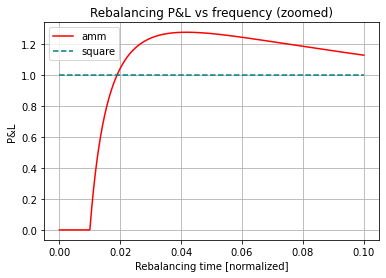

In [18]:
plt.plot(tt_r, A(lambda t: E(lambda x: amm_f(x,feepc),t) / t, tt_r), color="red", label="amm")
plt.plot(tt_r, A(lambda t: E(square2_f,t) / t, tt_r), linestyle="dashed", color="teal", label="square")
plt.legend()
plt.title(f"Rebalancing P&L vs frequency (zoomed)")
plt.xlabel("Rebalancing time [normalized]")
plt.ylabel("P&L")
plt.grid()

As reference we have also plotted the AMM profile with a zero fee level below where we see it diverging.

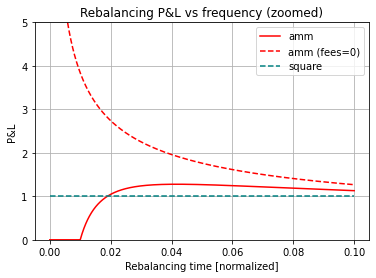

In [19]:
plt.plot(tt_r, A(lambda t: E(lambda x: amm_f(x,feepc),t) / t, tt_r), color="red", label="amm")
plt.plot(tt_r, A(lambda t: E(lambda x: amm_f(x,0),t) / t, tt_r), linestyle="dashed", color="red", label="amm (fees=0)")
plt.plot(tt_r, A(lambda t: E(square2_f,t) / t, tt_r), linestyle="dashed", color="teal", label="square")
plt.legend()
plt.title(f"Rebalancing P&L vs frequency (zoomed)")
plt.xlabel("Rebalancing time [normalized]")
plt.ylabel("P&L")
plt.ylim(0,5)
plt.grid()

## Part 3 -- Impact of fees

In [20]:
p0 = 1000     # current price
fee = 0.001   # fee (as fraction; eg 0.001 = 0.10%)
rg = 0.01     # viewport range (as fraction)

p_r = np.linspace((1-rg)*p0,(1+rg)*p0, 200)         # price range [p0*(1+-rg)]
gamma_r = A(lambda x: gamma_gain(p0,x), p_r)        # gamma gain as function of price p in p_r
fee_r = A(lambda x:fee_payment(fee,x), p_r)         # fee as function of price p in p_r

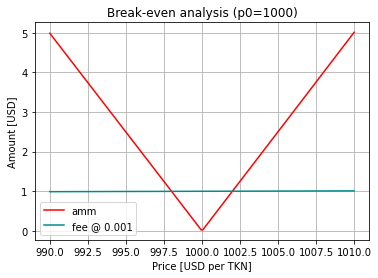

In [21]:
plt.plot(p_r, gamma_r, color="red", label="amm")
plt.plot(p_r, fee_r, color="darkcyan", label=f"fee @ {fee}")
plt.title(f"Break-even analysis (p0={p0})")
plt.xlabel("Price [USD per TKN]")
plt.ylabel("Amount [USD]")
plt.legend()
plt.grid()

We now determine the breakeven price $p_{be}=p_{be}(\phi)$ where the gain on the Gamma breaks even with the fees.

In [22]:
p0_,p_,fee_ = symbols("p_0 p \phi", real=True, positive=True)

In [23]:
breakeven_eq = Eq(abs_(p_-sqrt_(p0_*p_)), p_*fee_)
breakeven_eq

Eq(Abs(sqrt(p)*sqrt(p_0) - p), \phi*p)

In [24]:
breakeven2_eq = Eq(fee_, abs_(1-sqrt_(p0_/p_)))
breakeven2_eq

Eq(\phi, Abs(1 - sqrt(p_0)/sqrt(p)))

In [25]:
Eq(p_, solve(breakeven2_eq, p_)[0])

Eq(p, p_0/(\phi + 1)**2)

Here we plot the breakevern price at a specific level of $p_0=1000$. We see for $\phi=0$ the breakeven price is $p=p_0$ and it then goes down slowly.

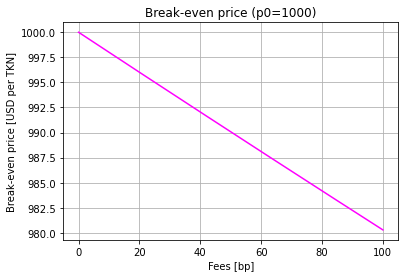

In [26]:
fees_r = np.linspace(0,100,500)
breakeven_r = A(lambda f: p0/(1+f/10000)**2, fees_r)

plt.plot(fees_r, breakeven_r, color="magenta", label="break-even price")
plt.title(f"Break-even price (p0={p0})")
plt.xlabel("Fees [bp]")
plt.ylabel("Break-even price [USD per TKN]")
plt.grid()

This is the same analysis but in relative terms. We see that at $\phi=0$ the breakeven level is at 100% (ie infinitesimal moves), and for increasing fees the breakeven level is approximately $p\simeq 1 - 2\phi$. In other words, at a fee level $\phi$, the breakeven percentage move is $2\phi$ in either direction.

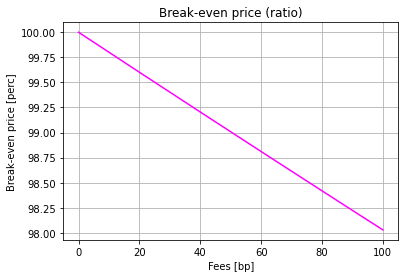

In [27]:
plt.plot(fees_r, breakeven_r/p0*100, color="magenta", label="break-even price")
plt.title(f"Break-even price (ratio)")
plt.xlabel("Fees [bp]")
plt.ylabel("Break-even price [perc]")
plt.grid()

### Simulation

In [28]:
sim = AMMSim(p0=100, feepc=0.10)
t = sim.trade_to(150)
print(f"p={sim.p_marg}, bleed={t.bleed:0.2f}, fee={t.fee:0.2f}, reverted={t.reverted}")
t = sim.trade_to(130)
print(f"p={sim.p_marg}, bleed={t.bleed:0.2f}, fee={t.fee:0.2f}, reverted={t.reverted}")
t = sim.trade_to(100)
print(f"p={sim.p_marg}, bleed={t.bleed:0.2f}, fee={t.fee:0.2f}, reverted={t.reverted}")

p=150.0, bleed=2.53, fee=1.12, reverted=False
p=150.0, bleed=0.29, fee=0.42, reverted=True
p=100.0, bleed=2.06, fee=1.12, reverted=False


Below we see a number of example of `create_prices`, creating price paths of differing granularity for covering the same time period. 

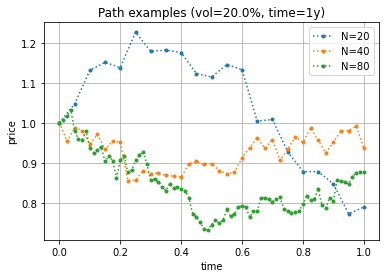

In [29]:
vol=0.2
T=1
for n, in zip([20,40,80]):
    plt.plot(np.linspace(0,1,n+1), create_prices(vol, n, T, add_p0=True), 
             linestyle="dotted", marker=".", label=f"N={n}")
plt.title(f"Path examples (vol={vol*100}%, time={T}y)")
plt.xlabel("time")
plt.ylabel("price")
plt.legend()
plt.grid()

In [30]:
sims = []
for _ in range(1000):
    p_r = create_prices(0.2, np.random.randint(10,1000))
    sim = AMMSim(p0=100,feepc=0.01)
    sims += [sim]
    for p in p_r:
        sim.trade_to(p)
    #print(sim.ntrades, sim.feecapture)

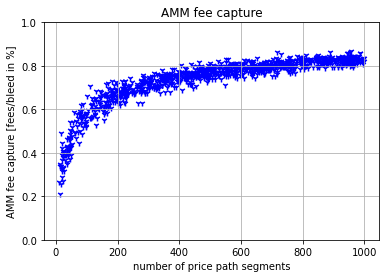

In [31]:
plt.scatter([s.ntrades for s in sims], [s.feecapture for s in sims], marker="1", color="blue")
plt.title("AMM fee capture")
plt.xlabel("number of price path segments")
plt.ylabel("AMM fee capture [fees/bleed in %]")
plt.ylim(0,1)
plt.grid()

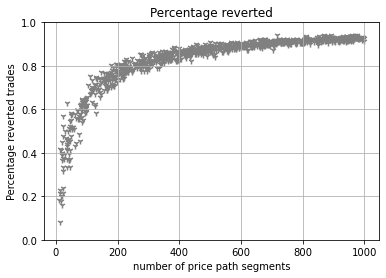

In [32]:
plt.scatter([s.ntrades for s in sims], [s.pcreverted for s in sims], marker="1", color="grey")
plt.title("Percentage reverted")
plt.xlabel("number of price path segments")
plt.ylabel("Percentage reverted trades")
plt.ylim(0,1)
plt.grid()

### Systematic analysis

In [33]:
N_r = np.array([10*1.5**n for n in range(23)])
SIGMA = 0.5

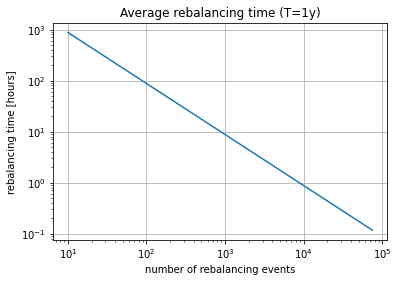

In [34]:
plt.plot(N_r, 24*365/N_r)
plt.title(f"Average rebalancing time (T=1y)")
plt.xlabel("number of rebalancing events")
plt.ylabel("rebalancing time [hours]")
plt.xscale("log")
plt.yscale("log")
plt.grid()

In [35]:
FEEPC = 0.001
feecapture_001_r = []
pcreverted_001_r = []
for n in N_r:
    n = int(n)
    print(f"N={n}")
    sims = []
    NN = int(100000/n)
    if NN < 20: NN = 20
    for _ in range(NN):
        p_r = create_prices(SIGMA, n)
        sim = AMMSim(p0=100,feepc=FEEPC)
        sims += [sim]
        for p in p_r:
            sim.trade_to(p)
    feecapture_001_r += [sum(s.feecapture for s in sims)/NN]
    pcreverted_001_r += [sum(s.pcreverted for s in sims)/NN]
print("DONE")

N=10
N=15
N=22
N=33
N=50
N=75
N=113
N=170
N=256
N=384
N=576
N=864
N=1297
N=1946
N=2919
N=4378
N=6568
N=9852
N=14778
N=22168
N=33252
N=49878
N=74818
DONE


In [36]:
N_r = [10*1.5**n for n in range(23)]
FEEPC = 0.005
feecapture_005_r = []
pcreverted_005_r = []
for n in N_r:
    n = int(n)
    print(f"N={n}")
    sims = []
    NN = int(100000/n)
    if NN < 20: NN = 20
    for _ in range(NN):
        p_r = create_prices(SIGMA, n)
        sim = AMMSim(p0=100,feepc=FEEPC)
        sims += [sim]
        for p in p_r:
            sim.trade_to(p)
    feecapture_005_r += [sum(s.feecapture for s in sims)/NN]
    pcreverted_005_r += [sum(s.pcreverted for s in sims)/NN]
print("DONE")

N=10
N=15
N=22
N=33
N=50
N=75
N=113
N=170
N=256
N=384
N=576
N=864
N=1297
N=1946
N=2919
N=4378
N=6568
N=9852
N=14778
N=22168
N=33252
N=49878
N=74818
DONE


In [37]:
N_r = [10*1.5**n for n in range(23)]
FEEPC = 0.01
feecapture_01_r = []
pcreverted_01_r = []
for n in N_r:
    n = int(n)
    print(f"N={n}")
    sims = []
    NN = int(100000/n)
    if NN < 20: NN = 20
    for _ in range(NN):
        p_r = create_prices(SIGMA, n)
        sim = AMMSim(p0=100,feepc=FEEPC)
        sims += [sim]
        for p in p_r:
            sim.trade_to(p)
    feecapture_01_r += [sum(s.feecapture for s in sims)/NN]
    pcreverted_01_r += [sum(s.pcreverted for s in sims)/NN]
print("DONE")

N=10
N=15
N=22
N=33
N=50
N=75
N=113
N=170
N=256
N=384
N=576
N=864
N=1297
N=1946
N=2919
N=4378
N=6568
N=9852
N=14778
N=22168
N=33252
N=49878
N=74818
DONE


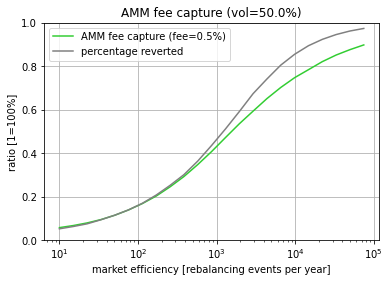

In [38]:
# plt.plot(N_r, feecapture_01_r, marker="", color="blue",label="AMM fee capture (fee=1%)")
# plt.plot(N_r, pcreverted_01_r, marker="", color="grey",label="percentage reverted")
plt.plot(N_r, feecapture_005_r, marker="", color="limegreen",label="AMM fee capture (fee=0.5%)")
plt.plot(N_r, pcreverted_005_r, marker="", color="grey",label="percentage reverted")
# plt.plot(N_r, feecapture_001_r, marker="", color="firebrick",label="AMM fee capture (fee=0.1%)")
# plt.plot(N_r, pcreverted_001_r, marker="", color="grey",label="percentage reverted")

plt.title(f"AMM fee capture (vol={SIGMA*100}%)")
plt.xlabel("market efficiency [rebalancing events per year]")
#plt.ylabel("AMM fee capture [fees/bleed in %]")
plt.ylabel("ratio [1=100%]")
plt.xscale("log")
plt.ylim(0,1)
plt.legend()
plt.grid()

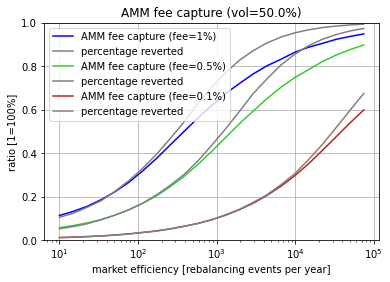

In [39]:
plt.plot(N_r, feecapture_01_r, marker="", color="blue",label="AMM fee capture (fee=1%)")
plt.plot(N_r, pcreverted_01_r, marker="", color="grey",label="percentage reverted")
plt.plot(N_r, feecapture_005_r, marker="", color="limegreen",label="AMM fee capture (fee=0.5%)")
plt.plot(N_r, pcreverted_005_r, marker="", color="grey",label="percentage reverted")
plt.plot(N_r, feecapture_001_r, marker="", color="firebrick",label="AMM fee capture (fee=0.1%)")
plt.plot(N_r, pcreverted_001_r, marker="", color="grey",label="percentage reverted")

plt.title(f"AMM fee capture (vol={SIGMA*100}%)")
plt.xlabel("market efficiency [rebalancing events per year]")
#plt.ylabel("AMM fee capture [fees/bleed in %]")
plt.ylabel("ratio [1=100%]")
plt.xscale("log")
plt.ylim(0,1)
plt.legend()
plt.grid()

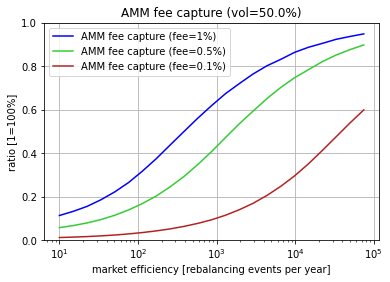

In [40]:
plt.plot(N_r, feecapture_01_r, marker="", color="blue",label="AMM fee capture (fee=1%)")
plt.plot(N_r, feecapture_005_r, marker="", color="limegreen",label="AMM fee capture (fee=0.5%)")
plt.plot(N_r, feecapture_001_r, marker="", color="firebrick",label="AMM fee capture (fee=0.1%)")

plt.title(f"AMM fee capture (vol={SIGMA*100}%)")
plt.xlabel("market efficiency [rebalancing events per year]")
#plt.ylabel("AMM fee capture [fees/bleed in %]")
plt.ylabel("ratio [1=100%]")
plt.xscale("log")
plt.ylim(0,1)
plt.legend()
plt.grid()

## Appendix -- approximating the Normal distribution

Below is the binary approximation of the Normal distribution, ie it is a distribution that is non-zero at only two points (where the density is a Dira delta function) and that matches the normal distribution in expectation and variance. Because of Central Limit Theorem we know that this approximation is very powerful as soon as the number of independent draws is sufficiently big. It is the basis of the binomial tree method of option pricing, which was extremely popular far into the 90s when computing power was limited.

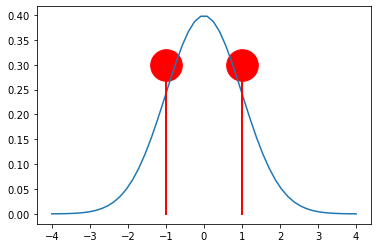

In [41]:
h = 0.3
x1_r = np.linspace(-4,4)
x2_r = [-1,-1,-1,-1, 1, 1,1,1]
y2_r = [0,h,0, None, None, 0,h,0]
plt.plot(x1_r, A(norm(0,1).pdf, x1_r))
plt.plot(x2_r, y2_r, color="red")
plt.scatter([-1,1], [h,h], s=1000, color="red")